In [96]:
import pandas as pd
herd = pd.read_csv('penguins.csv')
herd.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [97]:
herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [98]:
herd.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

In [99]:
herd[herd['CulmenLength'].isnull()]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


In [100]:
herd.dropna(inplace = True)

In [101]:
features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
target = 'Species'
X, y = herd[features], herd[target]
print('X:')
display(X)
print('\ny:')
display(y)

X:


,CulmenLength,CulmenDepth,FlipperLength,BodyMass
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0



y:


0      0
1      0
2      0
4      0
5      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: Species, Length: 342, dtype: int64

In [102]:
y.value_counts(normalize=True)

0    0.441520
1    0.359649
2    0.198830
Name: Species, dtype: float64

In [103]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Unique values: 164


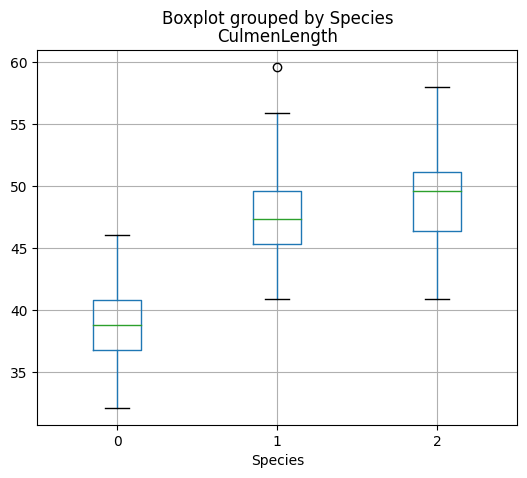

Unique values: 80


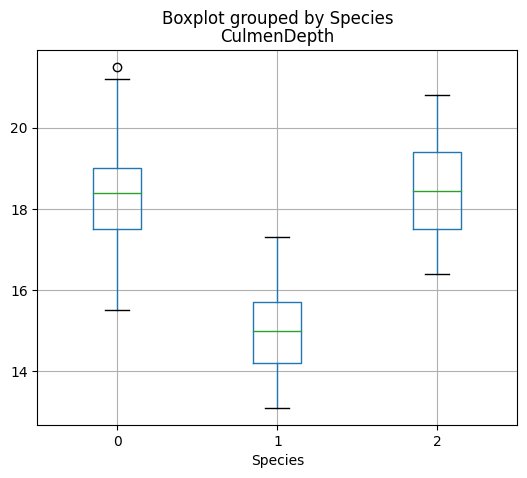

Unique values: 55


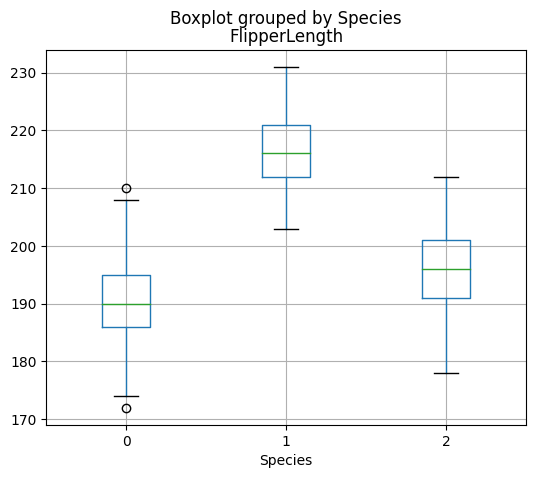

Unique values: 94


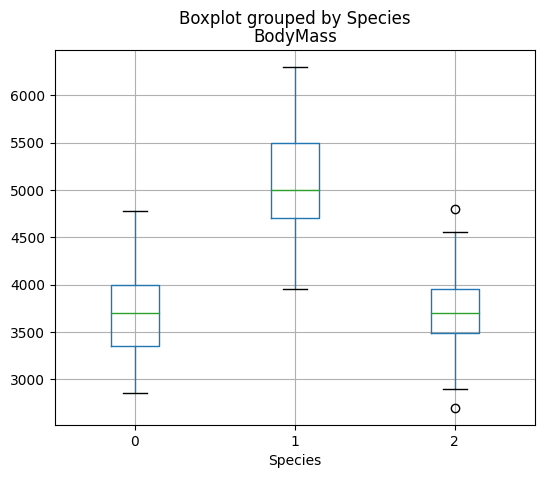

In [104]:
import matplotlib.pyplot as plt
for col in features:
    print(f'Unique values: {len(herd[col].unique())}')
    herd.boxplot(column=col, by='Species', figsize=(6,5))
    plt.title(col)
    plt.show()

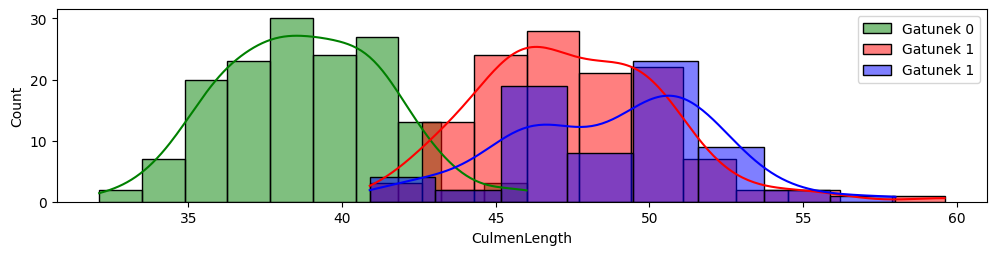

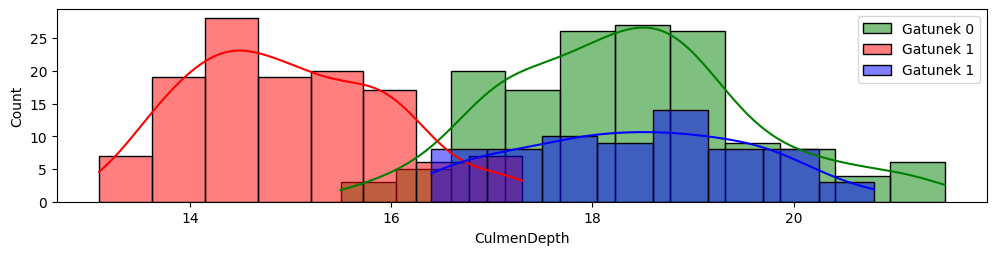

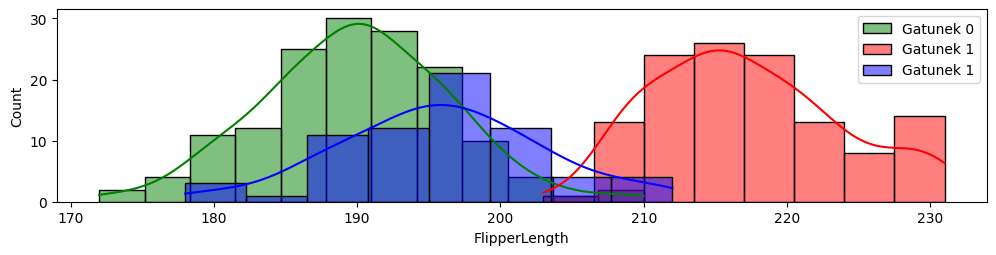

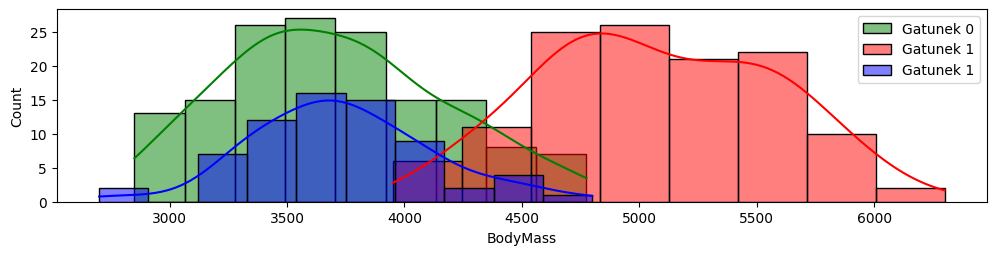

In [105]:
import seaborn as sns
for col in features:
    plt.figure(figsize=(12, 2.5))
    sns.histplot(herd.loc[herd['Species']==0, col], kde=True, color='green', label='Gatunek 0')
    sns.histplot(herd.loc[herd['Species']==1, col], kde=True, color='red', label='Gatunek 1')
    sns.histplot(herd.loc[herd['Species']==2, col], kde=True, color='blue', label='Gatunek 1')
    plt.legend(loc='upper right')
    plt.show()

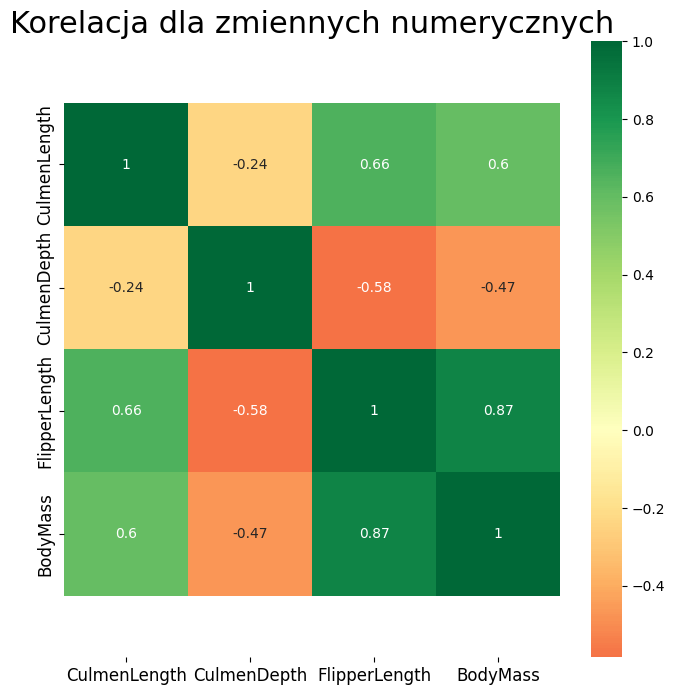

In [106]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)

plt.title('Korelacja dla zmiennych numerycznych', fontsize=22)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [107]:
from scipy import stats

corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

Na podstawie powyższych wyników, można zaobserwować że gatunek pingiwna zależny jest najbardziej od CulmenLength i FlipperLength.

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X[['CulmenLength', 'FlipperLength']], 
    y, 
    test_size=0.20,
    random_state=0, 
    stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

Treningowe obserwacje: 273
Testowe obserwacje: 69


In [109]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score_test','F1_score_train','AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked, X_trained,y_trained):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_train= model.predict(X_trained)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric_test = f1_score(y_checked, predictions,average = 'weighted')
    f1_metric_train = f1_score(y_trained, predictions_train,average = 'weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba,multi_class = 'ovo')

    metrics_dataframe = metrics_dataframe.append({
                                                'Model': name,
                                                'F1_score_test': f1_metric_test,
                                                'F1_score_train': f1_metric_train, 
                                                'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

Logistic Regression

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       1.00      1.00      1.00        25
           2       0.92      0.79      0.85        14

    accuracy                           0.94        69
   macro avg       0.94      0.92      0.93        69
weighted avg       0.94      0.94      0.94        69



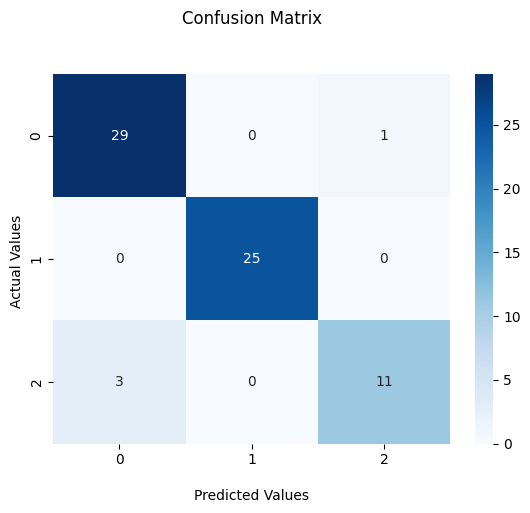

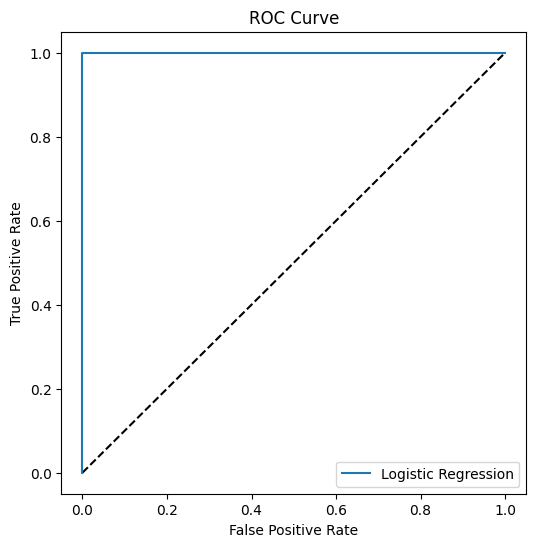

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429


In [110]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)
calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test, X_train_standardized, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best hyperparameter: {'n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       1.00      0.96      0.98        25
           2       0.86      0.86      0.86        14

    accuracy                           0.94        69
   macro avg       0.93      0.93      0.93        69
weighted avg       0.94      0.94      0.94        69



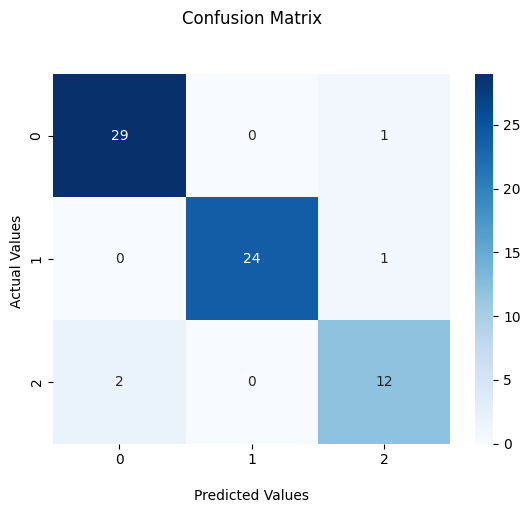

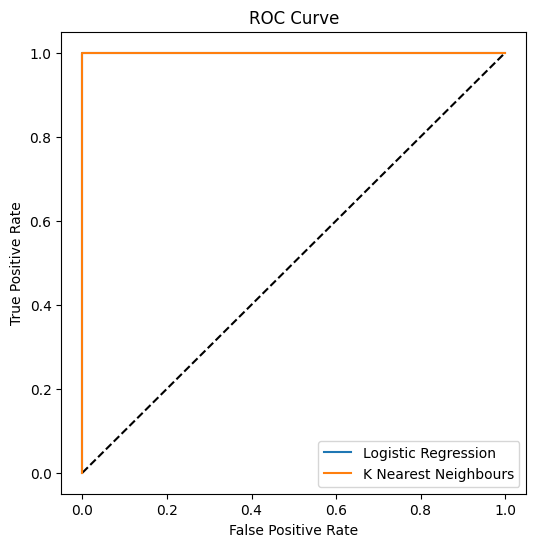

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429
1,K Nearest Neighbours,0.942237,0.981757,0.953571


In [111]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

random_knn = KNeighborsClassifier()
params_knn = {'n_neighbors': [3, 5, 10, 20]}
knn_gridsearch = GridSearchCV(random_knn,
                             params_knn,
                             scoring='f1_weighted',
                             cv=5,
                             verbose=10, n_jobs=-1)
knn_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', knn_gridsearch.best_params_)
model_knn = knn_gridsearch.best_estimator_

calculate_metrics(model_knn, 'K Nearest Neighbours', X_test_standardized, y_test, X_train_standardized, y_train)


Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 3}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       1.00      0.96      0.98        25
           2       0.86      0.86      0.86        14

    accuracy                           0.94        69
   macro avg       0.93      0.93      0.93        69
weighted avg       0.94      0.94      0.94        69



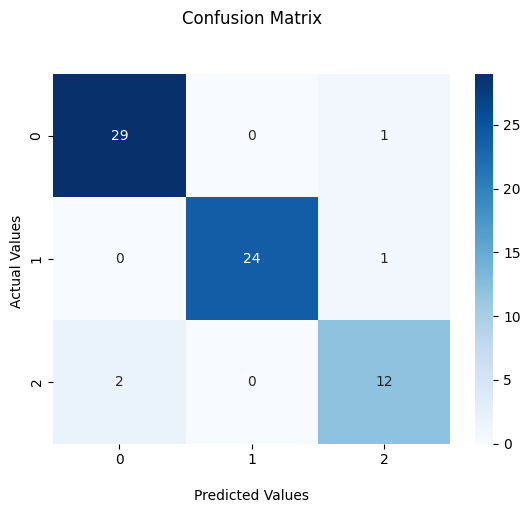

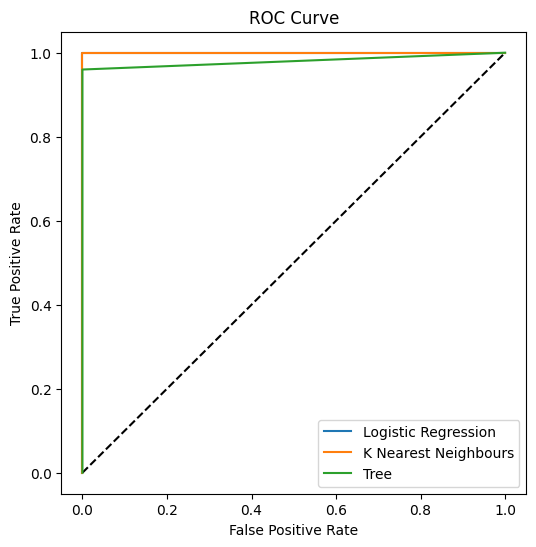

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429
1,K Nearest Neighbours,0.942237,0.981757,0.953571
2,Tree,0.942237,0.981738,0.944984


In [112]:
from sklearn.tree import DecisionTreeClassifier

random_tree = DecisionTreeClassifier()
params_tree = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
tree_gridsearch = GridSearchCV(random_tree,
                             params_tree,
                             scoring='f1_weighted',
                             cv=5,
                            )
tree_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_gridsearch.best_params_)
model_tree = tree_gridsearch.best_estimator_

calculate_metrics(model_tree, 'Tree', X_test, y_test, X_train, y_train)

SVM

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best hyperparameter: {'C': 3}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       1.00      1.00      1.00        25
           2       0.92      0.79      0.85        14

    accuracy                           0.94        69
   macro avg       0.94      0.92      0.93        69
weighted avg       0.94      0.94      0.94        69



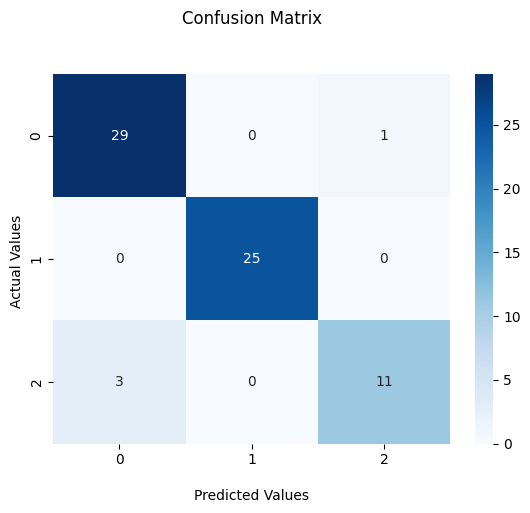

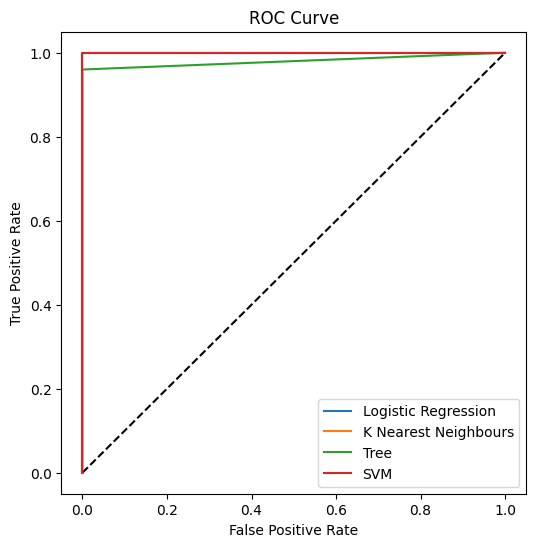

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429
1,K Nearest Neighbours,0.942237,0.981757,0.953571
2,Tree,0.942237,0.981738,0.944984
3,SVM,0.940734,0.963037,0.987222


In [113]:
from sklearn.svm import SVC

random_svm = SVC(probability=True)
params_svm = {'C' : [1,3,5,7,10,20,50,100]}
svm_gridsearch = GridSearchCV(random_svm,
                             params_svm,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
svm_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', svm_gridsearch.best_params_)
model_svm= svm_gridsearch.best_estimator_
model_svm.fit(X_train_standardized, y_train)
calculate_metrics(model_svm, 'SVM', X_test_standardized, y_test, X_train_standardized, y_train)

RandomForest

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 10}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       1.00      1.00      1.00        25
           2       0.92      0.79      0.85        14

    accuracy                           0.94        69
   macro avg       0.94      0.92      0.93        69
weighted avg       0.94      0.94      0.94        69



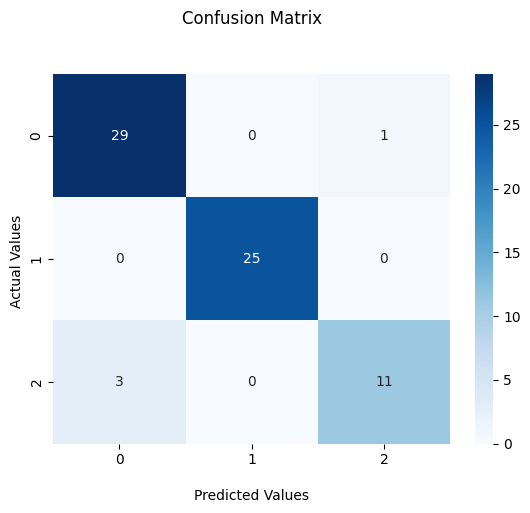

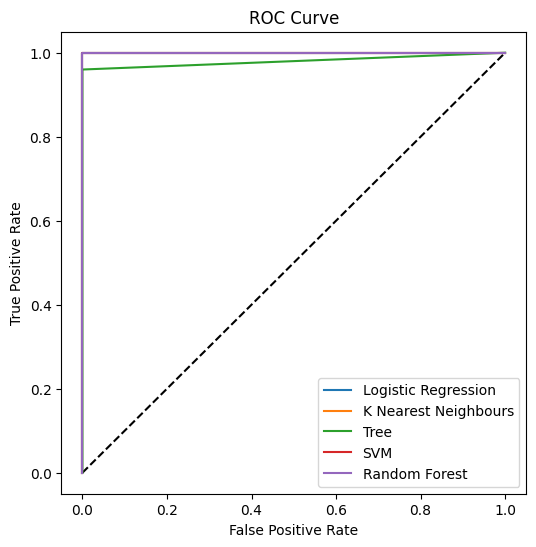

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429
1,K Nearest Neighbours,0.942237,0.981757,0.953571
2,Tree,0.942237,0.981738,0.944984
3,SVM,0.940734,0.963037,0.987222
4,Random Forest,0.940734,0.955605,0.985905


In [114]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
params_forest = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
forest_gridsearch = GridSearchCV(random_forest,
                             params_forest,
                             scoring='f1_weighted',
                             cv=5,
                             verbose=10, n_jobs=-1)
forest_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', forest_gridsearch.best_params_)
model_forest = forest_gridsearch.best_estimator_

calculate_metrics(model_forest, 'Random Forest', X_test, y_test, X_train, y_train)

AdaBoost

Fitting 10 folds for each of 7 candidates, totalling 70 fits


c:\Users\sliwi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Best hyperparameter: {'n_estimators': 3}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       1.00      1.00      1.00        25
           2       0.92      0.79      0.85        14

    accuracy                           0.94        69
   macro avg       0.94      0.92      0.93        69
weighted avg       0.94      0.94      0.94        69



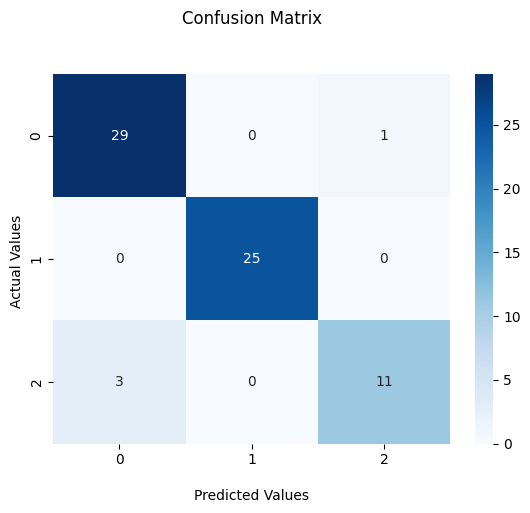

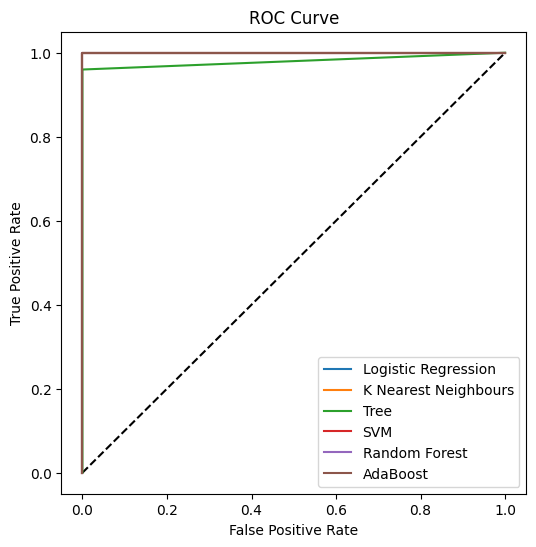

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429
1,K Nearest Neighbours,0.942237,0.981757,0.953571
2,Tree,0.942237,0.981738,0.944984
3,SVM,0.940734,0.963037,0.987222
4,Random Forest,0.940734,0.955605,0.985905
5,AdaBoost,0.940734,0.951785,0.957619


In [115]:
from sklearn.ensemble import AdaBoostClassifier
random_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
params_adaboost = {'n_estimators': [1,3,5,10,20,30,50]
             }
adaboost_gridsearch = GridSearchCV(random_adaboost,
                             params_adaboost,
                             scoring='f1_weighted',
                             cv=10,
                             verbose=10, n_jobs=-1)
adaboost_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:',adaboost_gridsearch.best_params_)
model_adaboost = adaboost_gridsearch.best_estimator_
calculate_metrics(model_adaboost, 'AdaBoost', X_test, y_test, X_train, y_train)


Voting Classifier

c:\Users\sliwi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       1.00      1.00      1.00        25
           2       0.92      0.86      0.89        14

    accuracy                           0.96        69
   macro avg       0.95      0.94      0.95        69
weighted avg       0.96      0.96      0.96        69



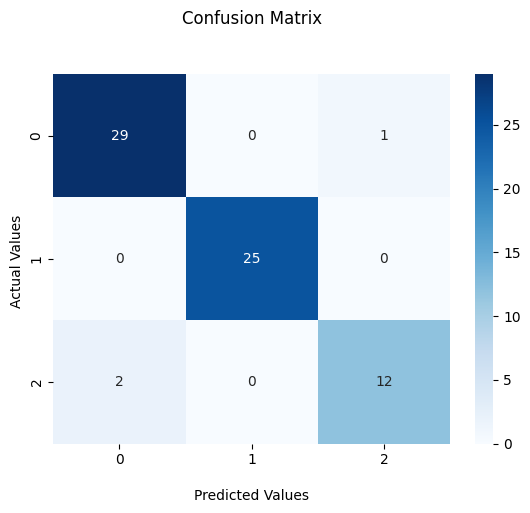

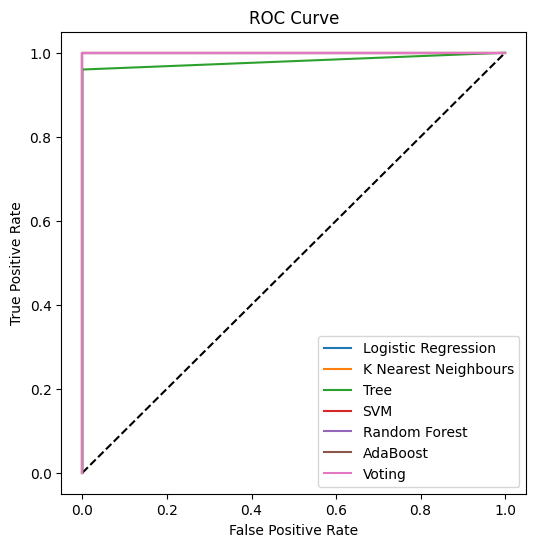

C:\Users\sliwi\AppData\Local\Temp\ipykernel_10892\2731615007.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({


,Model,F1_score_test,F1_score_train,AUC
0,Logistic Regression,0.940734,0.963037,0.990429
1,K Nearest Neighbours,0.942237,0.981757,0.953571
2,Tree,0.942237,0.981738,0.944984
3,SVM,0.940734,0.963037,0.987222
4,Random Forest,0.940734,0.955605,0.985905
5,AdaBoost,0.940734,0.951785,0.957619
6,Voting,0.956073,0.974458,0.987238


In [116]:
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators=[('Tree', model_tree),
                                            ('Random Forest', model_forest),
                                            ('AdaBoost', model_adaboost)],
                                voting='soft')

model_voting.fit(X_train, y_train)
calculate_metrics(model_voting, 'Voting', X_test, y_test, X_train, y_train)

In [117]:
metrics_dataframe.sort_values(by="F1_score_test", ascending=False)

,Model,F1_score_test,F1_score_train,AUC
6,Voting,0.956073,0.974458,0.987238
1,K Nearest Neighbours,0.942237,0.981757,0.953571
2,Tree,0.942237,0.981738,0.944984
0,Logistic Regression,0.940734,0.963037,0.990429
3,SVM,0.940734,0.963037,0.987222
4,Random Forest,0.940734,0.955605,0.985905
5,AdaBoost,0.940734,0.951785,0.957619
